In [18]:

cd ~/Desktop/covid_machinations

/Users/edwardterrell/Desktop/covid_machinations


In [19]:
pwd

'/Users/edwardterrell/Desktop/covid_machinations'

In [20]:
# we want to ensure we are in the correct conda environment
import sys
sys.executable

'/Users/edwardterrell/opt/anaconda3/envs/dataviz/bin/python'

In [21]:
# os, shutil used for copying/moving files
import os
import shutil
# shutil.copyfile('src', 'dst')
# shutil.move

import numpy as np
import pandas as pd
import openpyxl

In [22]:
# This code was used when repeatedly modifying date_checker module
#import importlib
#importlib.import_module('state_country_dicts') #note difference between this and reload
#importlib.reload(dc) #date_checker

In [23]:
# Custom pie_dict module contains only one function (pie) which reduces 
# the number of types into only seven basic categories for creating piecharts
from pie_dict import pie

In [24]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup as bs
# import regular expressions
import re 

from IPython.display import Image
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

# get current date for use in creating filenames with embedded 'day'. 
# convert datetime object to string
import datetime as dt
today  = dt.date.today()
day = today.strftime('%Y-%m-%d')
day

'2021-12-23'

### The following cell determines if the Colorado site has been updated

In [25]:
# outbreaks files are updated on the web once a week usually Wed afternoon
# date_checker is a custom python module that compares the date of the
# last saved outbreak.xlsx file to the date of the outbreak.xlsx
# file on the web
import date_checker as dc

#Returns the date of the latest saved spreadsheet.
previous = dc.get_date()


# compare function outputs a tuple: url link and a date
# and prints the dates of the spreadsheets
names = dc.compare(previous)

latest saved spreadsheet is 2021-12-15
COVID-19 OB Weekly Report 12 22 2021.xlsx
https://covid19.colorado.gov/sites/covid19/files/documents/COVID-19%20OB%20Weekly%20Report%2012%2022%202021.xlsx
Site UPDATED! current date of spreadsheet is 2021-12-22
OK to continue


In [26]:
# Examine the tuple
print (names[0])
print (names[1])

https://covid19.colorado.gov/sites/covid19/files/documents/COVID-19%20OB%20Weekly%20Report%2012%2022%202021.xlsx
2021-12-22 00:00:00


### Colorado Outbreak data

In [27]:
import urllib
import requests
import re

url = 'https://covid19.colorado.gov/data/outbreak-data'

In [28]:
ls

ColoradoOutbreaks.ipynb  covid.ipynb              pie_dict.py*
LICENSE                  covid_data/              state_country_dicts.py
README.md                date_checker.py*         style-notebook.css
__pycache__/             environment.yml          style-table.css
boulder-2021-12-20.csv   flist_of_covid_png       temp.xlsx


In [29]:
!mkdir covid_data_update

In [30]:
ls covid_data_update/

In [31]:
def get_weekly_report(names):
    '''
    Opens the web page and creates a copy of the xlsx file,
    which is then archived in the directory covid_data.
    
    names is the tuple variable created by data_checker.compare()
    the two components of names are: 1) url link and 2)date in string format
    
    returns a dataframe
    '''
    link = names[0]
    response = requests.get(link)
    with open ('temp.xlsx', 'wb') as file:
        file.write(response.content)
    
    # create a permanent copy of the xlsx file in the covid_data directory
    current = names[1]
    current_report = current.strftime('%Y-%m-%d')
    shutil.copyfile('temp.xlsx', f'covid_data/covid_report_{current_report}.xlsx')
    
    df = pd.read_excel('temp.xlsx',sheet_name='Active',engine='openpyxl',parse_dates=['Date reported to public health'])
    return df

In [32]:
df = get_weekly_report(names)
df.shape

(660, 65)

In [33]:
df = df.iloc[:,:16]
df.head(3)

,Setting name,Investigation status,Date outbreak was considered closed:,COVID Setting Type,"If setting type is other, specify","Is this an At Risk Population? (Healthcare, Corrections, Highly Mobile, Schools, Critical Infrastructure)",Colorado county (exposure location),Date reported to public health,Total resident cases,Total staff cases,Total attendee cases,Total resident deaths,Total staff deaths,Total attendee deaths,Total cases,Total deaths
0,48th Avenue - Catholic Charities Women's Shelter,Active,NaN,Homeless Shelter,NaN,Yes,Denver,2021-12-03,18.0,1.0,NaN,NaN,NaN,NaN,19,0
1,48th Avenue Center - Denver Rescue Mission,Active,NaN,Homeless Shelter,NaN,Yes,Denver,2021-08-27,106.0,2.0,NaN,NaN,NaN,NaN,108,0
2,4th Judicial District Attorney's Office: Octob...,Active,NaN,Law Enforcement Administration,NaN,Yes,El Paso,2021-10-25,NaN,14.0,NaN,NaN,NaN,NaN,14,0


In [34]:
def polish_report(df):
    '''polish_report removes and reorders columns and assigns shortened names. It also
    creates a datetime index, changes strings to integers and handles NaNs
    Returns: a copy of the original df
    '''
    # eliminate unnecessary columns and re-order columns
    df = df.iloc[:,[-2,0,3,6,7,8,9,10]].copy()
    
    # shorten col names for easier manipulation
    df.columns = ['total','name','type', 'county','date','residents','staff','attendee']
    
    # use the date column as the index
    df.index = df.date
    df.drop('date',axis=1, inplace=True)
    
    # replace nuisance commas
    df.name = df.name.str.replace(',','_')
    
    # fill na with 0 and turn strings to integers
    df = df.fillna(0)
    df['attendee'] = df['attendee'].astype(int) 
    df['staff'] = df['staff'].astype(int) 
    df['residents'] = df['residents'].astype(int)
    
    return df

In [35]:
df = polish_report(df)
# Sanity Check!!!
df.sort_index(ascending=False).head(10)

,total,name,type,county,residents,staff,attendee
date,,,,,,,
2021-12-22,2,The Rehabilitation Center at Sandalwood (02046...,Healthcare - Skilled Nursing,Jefferson,0,2,0
2021-12-21,14,Urban Lights,Retailer,Denver,0,14,0
2021-12-21,2,Solange at Appletree Assisted Living (2305I0):...,Healthcare - Assisted Living,El Paso,1,1,0
2021-12-21,10,St. Anne's Episcopal School: December 2021,School K-12,Denver,0,1,9
2021-12-21,3,Neurorestorative Colorado (02E996): December 2021,Healthcare - Skilled Nursing,Jefferson,0,3,0
2021-12-21,5,The Suites at Someren Glen Care Center (020471...,Healthcare - Skilled Nursing,Arapahoe,4,1,0
2021-12-21,6,Broomfield High School: December 2021,School K-12,Broomfield,0,0,6
2021-12-21,4,Archuleta County Jail,Jail,Archuleta,2,2,0
2021-12-21,5,Mesa County Work Release/Community Corrections...,"Correctional, Other",Mesa,3,2,0


### outbreaks

In [36]:
# this saves four csv files for easy viewing access even on an ipad organized by county,type, total and date
# use of f-string to allow 'day' to be interpreted correctly
df.sort_values(by='county', inplace=True)
df.to_csv(f'./covid_data_update/outbreaks-COUNTY-{day}.csv')

df.sort_values(by='type', inplace=True)
df.to_csv(f'./covid_data_update/outbreaks-TYPE-{day}.csv')

df.sort_values(by='total', inplace=True,ascending=False)
df.to_csv(f'./covid_data_update/outbreaks-TOTAL-{day}.csv')

df =df.sort_index(ascending=False)
df.to_csv(f'./covid_data_update/outbreaks-DATE-{day}.csv')

# total active
print(f'There are {df.shape[0]} outbreak sites and {df.total.sum()} active cases in Colorado')

There are 660 outbreak sites and 19356 active cases in Colorado


In [37]:
# prompt user to select month (default is current month)
# selecting months in the distant past may yield incorrect values
m = input('Select the month by number (update only recent months):') or names[1].month
y = names[1].year
m = int(m)
print(f'Updating df_month for year {y} and month {m}')

Select the month by number (update only recent months): 


Updating df_month for year 2021 and month 12


In [38]:
# Future modification planned to show data across year boundaries
# dfy is the df for the current year
dfy = df[df.index.year==y].copy()

In [39]:
# df_month is the df for the selected month
df_month = dfy[dfy.index.month==m].copy()

In [40]:
df_month.reset_index(inplace=True)
df_month = df_month[['total','name','type','county']]

In [41]:
df_month.to_csv(f'./covid_data/covid_2021_{m}.txt')

In [42]:
# get number of sites and total cases for the month
s_num = df_month.shape[0]
t = df_month.total.sum()
print(f'There were an additional {s_num} outbreak sites in Colorado this month.')
print (f'These represent a total of {t} new cases.')

There were an additional 156 outbreak sites in Colorado this month.
These represent a total of 1342 new cases.


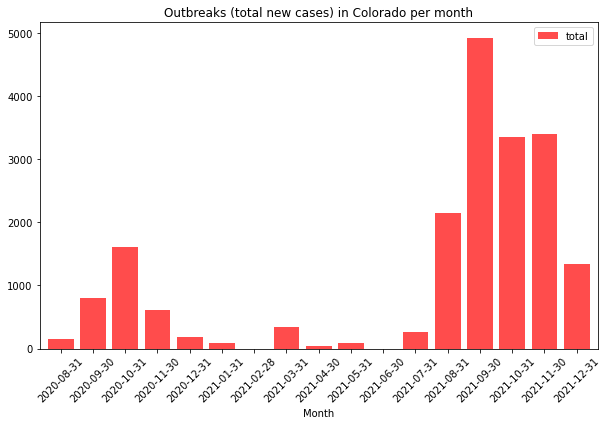

In [43]:
dfm = df.resample('M').sum()
dfm['Month'] = dfm.index.date
dfm

dfm[['Month','total']].plot.bar(figsize=(10,6), \
                                x='Month',rot=45, width=.8, \
                                color="red",alpha=.7,\
                                title="Outbreaks (total new cases) in Colorado per month")
plt.savefig(f'./covid_data_update/outbreaks-per-month-{day}.png');

In [ ]:
dfm.sort_index(ascending = False)

In [44]:
# list all active cases in Boulder County
boulder = df[df.county=='Boulder']
bc = boulder.total.sum()
print(f'There are {bc} active cases in Boulder County')

There are 388 active cases in Boulder County


In [45]:
boulder = boulder.sort_index(ascending=False)
boulder.to_csv(f'./covid_data_update/boulder-{day}.csv')
boulder

,total,name,type,county,residents,staff,attendee
date,,,,,,,
2021-12-16,16,Mesa Vista of Boulder (020380): December 2021,Healthcare - Skilled Nursing,Boulder,7,9,0
2021-12-14,3,The Carillon at Boulder Creek (23V719),Healthcare - Assisted Living,Boulder,1,2,0
2021-12-08,10,Centennial Peaks Hospital,Healthcare - Psychiatric Hospital,Boulder,3,7,0
2021-12-06,3,Altavita Memory Care Center (23H130): December...,Healthcare - Skilled Nursing,Boulder,1,2,0
2021-12-06,2,Balfour Longmont (23L108): December 2021,Healthcare - Assisted Living,Boulder,1,1,0
2021-12-03,2,Manor Health Services - Boulder (020315): Nove...,Healthcare - Skilled Nursing,Boulder,0,2,0
2021-12-02,2,Linden Place Health and Rehabilitation Center ...,Healthcare - Skilled Nursing,Boulder,0,2,0
2021-12-02,7,Primrose School of Longmont: November 2021,Child Care Center,Boulder,0,3,4
2021-12-02,5,SonShine Daycare and Preschool,Child Care Center,Boulder,0,2,3


### Create Pie Chart

In [46]:
# total number of active cases
s = df.total.sum()
s

19356

In [47]:
# list of major types by percent of total
df_percent = df.groupby('type').total.sum()/s
print (f'These represent {df_percent[df_percent > .01].sum()*100:.0f}% of all outbreak cases')
df_percent[df_percent > .01]

These represent 91% of all outbreak cases


type
Child Care Center                           0.019735
College/University                          0.036991
Construction Company/Contractor             0.019322
Distribution Center/Business                0.028673
Healthcare - Assisted Living                0.018031
Healthcare - Independent Living Facility    0.011159
Healthcare - Psychiatric Hospital           0.011779
Healthcare - Skilled Nursing                0.043656
Homeless Shelter                            0.017204
Hotel/Lodge/Resort                          0.020562
Jail                                        0.174675
Office/Indoor Workspace                     0.028932
Other                                       0.018392
Retailer                                    0.012968
School K-12                                 0.432476
State Prison                                0.016016
Name: total, dtype: float64

In [48]:
# custom function from pie_dict 
from pie_dict import pie

In [49]:
df_pie = pie (df)
df_pie.head()
pie_list = np.array(['College/University', 'Jail/Prison', 'Other',
       'Office/Mfg/Dist/Construction', 'Healthcare', 'Resturant/Retail',
       'Day Care/School'], dtype=object)

,total,name,type,county,residents,staff,attendee
date,,,,,,,
2021-12-22,2,The Rehabilitation Center at Sandalwood (02046...,Healthcare,Jefferson,0,2,0
2021-12-21,10,St. Anne's Episcopal School: December 2021,Day Care/School,Denver,0,1,9
2021-12-21,4,Archuleta County Jail,Jail/Prison,Archuleta,2,2,0
2021-12-21,3,Neurorestorative Colorado (02E996): December 2021,Healthcare,Jefferson,0,3,0
2021-12-21,6,Broomfield High School: December 2021,Day Care/School,Broomfield,0,0,6


In [50]:
'''test = df.type.unique()
test = np.append(test,['Social Gathering','Travel'])
len(test)
'''

"test = df.type.unique()\ntest = np.append(test,['Social Gathering','Travel'])\nlen(test)\n"

In [51]:
df.type.unique()

array(['Healthcare', 'Day Care/School', 'Jail/Prison', 'Other',
       'Resturant/Retail', 'Office/Mfg/Dist/Construction',
       'Municipal/Local Government', 'College/University'], dtype=object)

In [52]:
def check_types(df):
    '''check_types checks to see if any new categories were added and 
    if so reassigns them to the Other category
    Returns: a copy of the original df
    '''
    test = df.type.unique()
    if len(test) != 7:
        more_types = [item for item in test if item not in pie_list]
        df.type = df.type.replace(dict.fromkeys(more_types, 'Other'))
        print(f'{more_types} were added to the category: Other')
    else:
        print('No new types were added to the category: Other')
        
    return df

In [53]:
df = check_types(df)

['Municipal/Local Government'] were added to the category: Other


In [54]:
df.total = df.total.astype(int)

p = df.groupby('type').total.sum()
print (p)
total_cases = p.sum()
total_cases

type
College/University               716
Day Care/School                 8811
Healthcare                      2000
Jail/Prison                     3824
Office/Mfg/Dist/Construction    1915
Other                           1434
Resturant/Retail                 656
Name: total, dtype: int64


19356

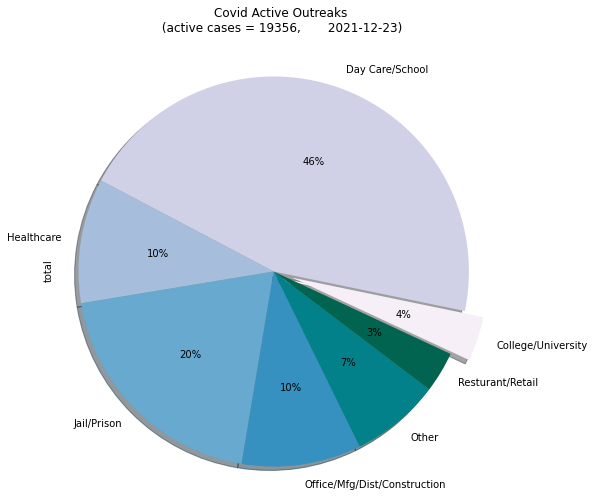

In [55]:
# creates a pie chart of the current total active cases
my_colors = ['#f6eff7','#d0d1e6','#a6bddb','#67a9cf','#3690c0','#02818a','#016450']

explode = (.1,0,0,0,0,0,0)

p.plot.pie(figsize=(8,8),explode=explode,autopct='%1.0f%%',
        shadow=True, colors=my_colors,startangle=-25);
plt.title(f'Covid Active Outreaks\n (active cases = {total_cases},       {day})\n')

plt.axis('equal')
plt.savefig(f'./covid_data_update/outbreaks-piechart-{day}.png');

### Change directory

In [56]:
cd covid_data_update

/Users/edwardterrell/Desktop/covid_machinations/covid_data_update


In [57]:
# Gathering summary statistics for a two month pie chart 
# create datetime and integers types 
this_month = pd.read_csv(f'outbreaks-DATE-{day}.csv')
this_month.date = pd.to_datetime(this_month.date)
this_month.total = this_month.total.astype(int)

In [58]:
# apply custom pie function
this_month = pie(this_month)

In [59]:
# Create string variables for the first day of the previous month and previous month
start = today - pd.offsets.MonthBegin (2)
str_date = start.strftime('%Y-%m-%d')
str_date
month = start.strftime('%B')
month

'2021-11-01'

'November'

In [60]:
#set filter to start month (month always starts on the first)
#check for new types
start_month = this_month[this_month.date > str_date].copy()
start_month = check_types(start_month)

['Municipal/Local Government'] were added to the category: Other


In [61]:
start_month = start_month.groupby('type').total.sum()
this_month_cases = start_month.sum()
start_month

type
College/University               160
Day Care/School                 2344
Healthcare                       928
Jail/Prison                      384
Office/Mfg/Dist/Construction     383
Other                            239
Resturant/Retail                 124
Name: total, dtype: int64

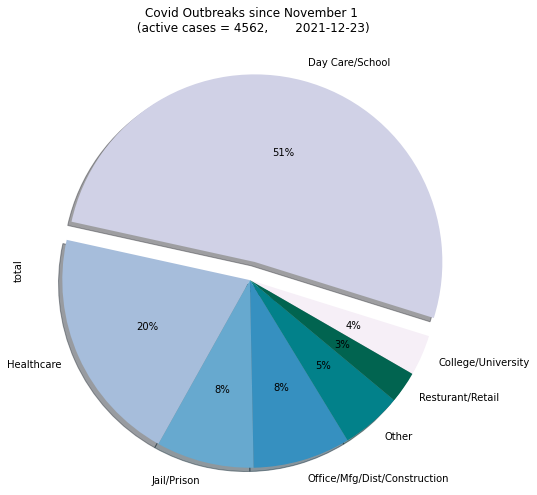

In [62]:
# creates a pie chart 
my_colors = ['#f6eff7','#d0d1e6','#a6bddb','#67a9cf','#3690c0','#02818a','#016450']

explode = (0,.1,0,0,0,0,0)

start_month.plot.pie(figsize=(8,8),explode=explode,autopct='%1.0f%%', 
             shadow=True, colors=my_colors,startangle=-30)

plt.title(f'Covid Outbreaks since {month} 1\n (active cases = {this_month_cases},       {day})\n')

plt.axis('equal')
plt.savefig(f'this_month_outbreaks-piechart-{day}.png');

### Displays all updated graphs files

['outbreaks-per-month-2021-12-23.png',
 'outbreaks-piechart-2021-12-23.png',
 'this_month_outbreaks-piechart-2021-12-23.png']

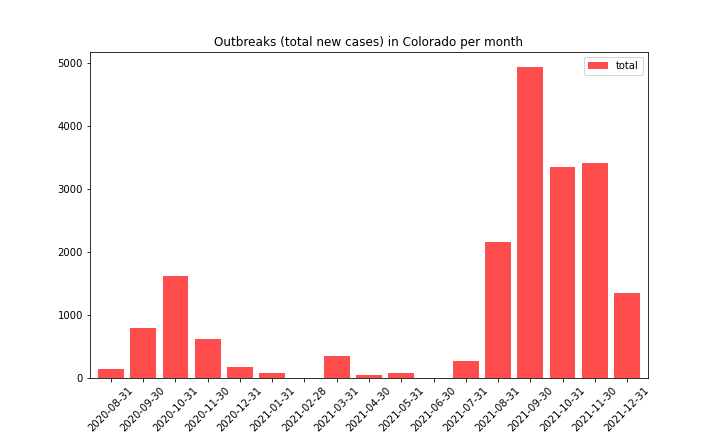

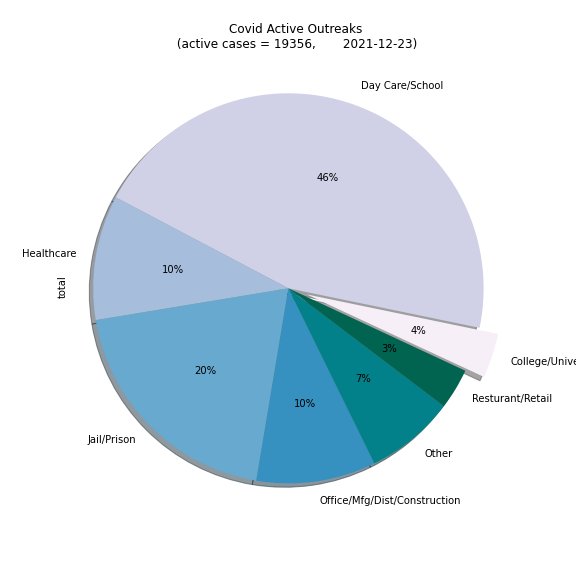

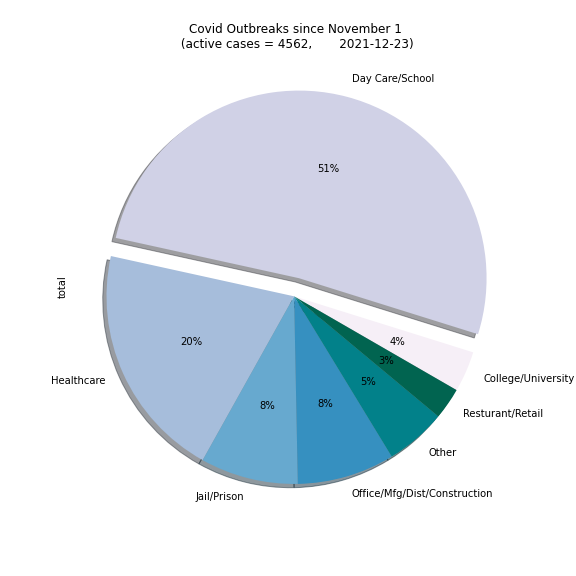

In [63]:
!ls -t1 | head -n 20 | grep -ve '^bolder' -ve 'png$' -ve 'xlsx$' > covid_text
!ls *.png > flist_of_covid_png 

# Loop through the file flist and store filenames in png_list
with open('flist_of_covid_png') as f:
    png_str = f.read()
png_list = png_str.split('\n')[0:-1]

png_list

from IPython.display import Image

for file in png_list:    
    local = Image(file)
    local
    
# These were helper files and are not needed any longer
!rm -f covid_text
!rm -f flist_of_covid_png
!rm -f temp.xlsx


### tabla rasa

In [64]:
!ls

boulder-2021-12-23.csv
outbreaks-COUNTY-2021-12-23.csv
outbreaks-DATE-2021-12-23.csv
outbreaks-TOTAL-2021-12-23.csv
outbreaks-TYPE-2021-12-23.csv
outbreaks-per-month-2021-12-23.png
outbreaks-piechart-2021-12-23.png
this_month_outbreaks-piechart-2021-12-23.png


In [ ]:
!rm -rf covid_data_update